In [148]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 1. Линейная регрессия. Реализация

In [149]:
data = load_boston()
data['data'].shape

(506, 13)

In [150]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1.1. Реализация линейной регрессии с использованием матричных операций

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где $X$ — матрица объекты-признаки, $y$ — вектор целевых значений, соответствующих $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$

Реализуем выражение для $\theta$ с помощью операций линейной алгебры библиотеки Numpy:

In [151]:
# ЗАДАЧА Реализовать функцию, осуществляющую матричные операции для получения theta
def linreg_linear(X, y):
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    return theta

In [152]:
# Подготовить данные

X, y = data['data'], data['target']
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [153]:
# Вычислить параметр theta
theta = linreg_linear(X, y)
theta

array([ 3.64594884e+01, -1.08011358e-01,  4.64204584e-02,  2.05586264e-02,
        2.68673382e+00, -1.77666112e+01,  3.80986521e+00,  6.92224640e-04,
       -1.47556685e+00,  3.06049479e-01, -1.23345939e-02, -9.52747232e-01,
        9.31168327e-03, -5.24758378e-01])

In [154]:
theta.shape

(14,)

In [155]:
# Сделать предсказания для тренировочной выборки
y_pred = X.dot(theta)

In [156]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [157]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


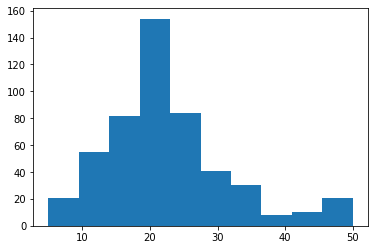

In [158]:
plt.hist(y);

In [159]:
# Разбить выборку на train/valid, вычислить theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [160]:
print_regression_metrics(y_valid, y_pred)
print_regression_metrics(y_train, y_train_pred)

MSE = 26.34, RMSE = 5.13
MSE = 20.96, RMSE = 4.58


In [161]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [162]:
# Реализовать функцию вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

In [163]:
# Реализовать функцию, осуществляющую градиентный шаг
# (функция должна содержать параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

In [164]:
# Реализовать функцию цикла градиентного спуска с доп. параметрами
# начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [165]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [166]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [167]:
theta

array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [168]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  1.    ,  88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,
         8.78  , 100.    ,  12.1265,  24.    , 711.    ,  22.    ,
       396.9   ,  37.97  ])

In [169]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

B
168.3704950393814


In [170]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [171]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)
# X

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [172]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

In [173]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [174]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [175]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68


In [176]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 19.50, RMSE = 4.42


In [177]:
data = load_boston()
data

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [178]:
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [179]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [231]:
X, y = data['data'], data['target']
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [232]:
from sklearn.linear_model import LinearRegression

# sklearn автоматически добавляет столбец единиц в свои модели
# Чтобы он этого не делал нужно в модель linear regression подать параметр fit_intercept = False
lr = LinearRegression(fit_intercept=False)
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 24.17, RMSE = 4.92


In [227]:
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
y = data['target']

X = df[df.B > 50]
y = y[df.B > 50]
X.shape, y.shape

lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.79, RMSE = 4.67


In [229]:
from sklearn import preprocessing
# X, y = data["data"], data["target"]
# X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
# X = (X - X.mean(axis=0)) / X.std(axis=0)
# m = X.shape[1]
# X = preprocessing.normalize(X)
# theta = linreg_linear(X, y)
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X.dot(theta)

# lr = LinearRegression()
# lr.fit(X,y)
# y_pred = lr.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68
